## L1 Norm Implementation. 

### A. Target
Take the last model (5th code), and run bellow versions for 25 epochs and report findings:

*   with L1 + BN
*   with L2 + BN
*   with L1 and L2 with BN
*   with with GBN
*   with L1 and L2 with GBN

### B. Results
*   L1 + BN
    1. Parameters: 9,912
    2. Best Training Accuracy in 25 epochs: 99.28%
    3. Best Test Accuracy in 25 epochs: 99.37%
*   L2 + BN
    1. Parameters: 9,912
    2. Best Training Accuracy in 25 epochs: 99.27%
    3. Best Test Accuracy in 25 epochs: 99.32%
*   L1 + L2 + BN
    1. Parameters: 9,912
    2. Best Training Accuracy in 25 epochs: 99.31%
    3. Best Test Accuracy in 25 epochs: 99.35%
*   GBN
    1. Parameters: 9,912
    2. Best Training Accuracy in 25 epochs: 99.16%
    3. Best Test Accuracy in 25 epochs: 99.38%
*   L1 + L2 + GBN
    1. Parameters: 9,912
    2. Best Training Accuracy in 25 epochs: 99.25%
    3. Best Test Accuracy in 25 epochs: 99.34%
    
### C. Analysis

With the application of regularization, we try to modify the loss function slightly. Regularization helps to deal with the problem of overfitting. We tried 5 models here and the summary of the analysis is -

*  L1+BN: We added the sum of weights as regularizer with lambda as 1e-6. Due to the effect of regularization the test and train accuracy gap got reduced though model coudn't reach to the earlier levels of above 99.40% accurcay
*  L2+BN: We used the weight decay parameter in the optimizer function for L2 Norm which is sum of squares of weights. L2 didn't better than L1 as the value of decay parameter is not appropriate and could be explored further
*  L1+L2+BN: L1 + L2 performed better than L2. The training accuracies shows L2 is more hard than L1 and L1+L2 combined
*  GBN: We used split of 2 and batch size of 4. GBN gave best training accuracy as splitting the batches acts as a regularizer which leads to better training and resulting into better test accuracy
*  L1+L2+GBN: The accurac gets reduced in comparision to GBN model but the model still performs better than other models


In [1]:
from google.colab import drive
drive.mount("/content/drive")

base_folder = 'drive/My Drive/eva5_stored_from_colab/s6/'
acc_recorder_file = "highest_accuracy_achieved"
model_file_name = "reg_"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from operator import itemgetter
import time

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

#Set Transforms - Transform part of ETL
Transforms are requried to convert the image data by applying various transformantions required. As of now, just convert image to tensor and normalize with whole dataset mean and standard deviation

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,) as this is one channel image, we have added one tuple for mean and std each 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train/Test Split - Extract part of ETL

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Architecture

In [6]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [7]:
import torch.nn.functional as F
dropout_value = 0.1
num_of_splits = 2
class Net(nn.Module):
    def __init__(self, is_gbn=False):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8) if is_gbn == False else GhostBatchNorm(8,num_of_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if is_gbn == False else GhostBatchNorm(16,num_of_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 26
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16) if is_gbn == False else GhostBatchNorm(16,num_of_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 11
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16) if is_gbn == False else GhostBatchNorm(16,num_of_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32) if is_gbn == False else GhostBatchNorm(32,num_of_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Summary

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 26, 26]           1,152
              ReLU-6           [-1, 16, 26, 26]               0
       BatchNorm2d-7           [-1, 16, 26, 26]              32
           Dropout-8           [-1, 16, 26, 26]               0
            Conv2d-9            [-1, 8, 26, 26]             128
        MaxPool2d-10            [-1, 8, 13, 13]               0
           Conv2d-11           [-1, 16, 11, 11]           1,152
             ReLU-12           [-1, 16, 11, 11]               0
      BatchNorm2d-13           [-1, 16, 11, 11]              32
          Dropout-14           [-1

# L1 Norm function

In [9]:
def calculate_l1_reg(model, lambda_l1):
  """Calculate L1 Norm"""
  l1 = 0
  for p in model.parameters():
    l1 = l1 + p.abs().sum()
  return(lambda_l1*l1)

# Train and Test Functions

In [10]:
train_losses = []
train_acc = []

def train(model, device, train_loader, optimizer, epoch, m_num, lambda_l1):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)     # Get batch
    optimizer.zero_grad() # Set the gradients to zero before starting to do backpropragation
    y_pred = model(data)  # Predict

    loss = F.nll_loss(y_pred, target) # Calculate loss

    if m_num in {0,2,4}:
      # Calculate the MSE and L1 
      l1 = calculate_l1_reg(model, lambda_l1)
      loss = loss + l1

    train_losses.append(loss) # Accumulate loss per batch

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return loss.item(), 100*correct/processed, train_losses, train_acc

test_losses = []
test_acc = []
def test(model, device, test_loader):

  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  
  test_acc.append(100. * correct / len(test_loader.dataset))

  return test_loss, 100. * correct / len(test_loader.dataset), test_losses, test_acc

def record_max_acc(max_acc):
  f = open(base_folder+acc_recorder_file, "w")
  f.write(str(max_acc))
  f.close()

# Let's Train and test our model

In [11]:
from torch.optim.lr_scheduler import StepLR

# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

try:
  with open(base_folder+acc_recorder_file, "r") as infl:
      max_acc = float(infl.read().strip())
except:
  max_acc = 0.0

model_dict = {0:'L1_BN', 1:'L2_BN', 2:'L1_L2_BN', 3:'GBN', 4:'L1_L2_GBN'}
tr_ls_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}
ts_ls_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}
tr_acc_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}
ts_acc_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}

MODELS = 5
for m_num in range(MODELS):
  train_losses = []
  train_acc = []
  test_losses = []
  test_acc = []
  max_acc = 0.0
  if m_num in {3,4}:
    model =  Net(is_gbn=True).to(device)
  else:  
    model =  Net().to(device)
  if m_num in {1,2,4}: # Apply L2 Norm
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
  else: 
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
  print(f'Model Name: ==================( {model_dict[m_num]} )==================')
  EPOCHS = 25
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc, tr_ls_dict[m_num], tr_acc_dict[m_num] = train(model, device, train_loader, optimizer, epoch, m_num, lambda_l1=1e-5)
      
    scheduler.step()
    tst_loss, tst_acc, ts_ls_dict[m_num], ts_acc_dict[m_num] = test(model, device, test_loader)

    if m_num == 3 and tst_acc > max_acc: # Store GBN Model
      max_acc = tst_acc
      torch.save(model.state_dict(), base_folder+model_file_name+model_dict[m_num]+"_sd.pth")
      record_max_acc(max_acc)

  print(f'Maximum Test Accuracy for {model_dict[m_num]} is {tst_acc}')
  print('=========================================================')


  0%|          | 0/469 [00:00<?, ?it/s]

Model Name: ==================( L1_BN )==================
EPOCH: 0


Loss=0.10490518808364868 Batch_id=468 Train Accuracy=93.29: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0754, Test Accuracy: 9766/10000 (97.66%)

EPOCH: 1


Loss=0.12814073264598846 Batch_id=468 Train Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Test Accuracy: 9875/10000 (98.75%)

EPOCH: 2


Loss=0.01851632446050644 Batch_id=468 Train Accuracy=98.35: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Test Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Loss=0.04802701994776726 Batch_id=468 Train Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9919/10000 (99.19%)

EPOCH: 4


Loss=0.045938003808259964 Batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.017736859619617462 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.027656087651848793 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.016686707735061646 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 8


Loss=0.03726881742477417 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.07543028146028519 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.03464416414499283 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.09357911348342896 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.05002391338348389 Batch_id=468 Train Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.02685556933283806 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.060796111822128296 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.06901972740888596 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.027275340631604195 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.02476576529443264 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.02216070517897606 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.02823975682258606 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.02147171087563038 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.03423185646533966 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.023708699271082878 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 23


Loss=0.053771428763866425 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.027439692988991737 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Test Accuracy: 9937/10000 (99.37%)

Maximum Test Accuracy for L1_BN is 99.37
Model Name: ==================( L2_BN )==================
EPOCH: 0


Loss=0.05765105411410332 Batch_id=468 Train Accuracy=92.78: 100%|██████████| 469/469 [00:13<00:00, 35.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Test Accuracy: 9772/10000 (97.72%)

EPOCH: 1


Loss=0.028570614755153656 Batch_id=468 Train Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Test Accuracy: 9840/10000 (98.40%)

EPOCH: 2


Loss=0.022874943912029266 Batch_id=468 Train Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Test Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.06275174021720886 Batch_id=468 Train Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 33.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Test Accuracy: 9851/10000 (98.51%)

EPOCH: 4


Loss=0.004262413829565048 Batch_id=468 Train Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.026557976379990578 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 6


Loss=0.0045556542463600636 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.013613245449960232 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.03335164859890938 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.004184149671345949 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.025124497711658478 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.00824925396591425 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.01737830601632595 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.004018711391836405 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.0050024488009512424 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.022892357781529427 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.0426439605653286 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.01990554668009281 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.012775910086929798 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.011363274417817593 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.01085639838129282 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Loss=0.033109959214925766 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.006104075815528631 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.019756797701120377 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 24


Loss=0.023631662130355835 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9932/10000 (99.32%)

Maximum Test Accuracy for L2_BN is 99.32
Model Name: ==================( L1_L2_BN )==================
EPOCH: 0


Loss=0.07197389006614685 Batch_id=468 Train Accuracy=93.53: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Test Accuracy: 9828/10000 (98.28%)

EPOCH: 1


Loss=0.09743942320346832 Batch_id=468 Train Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Test Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.24151679873466492 Batch_id=468 Train Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Test Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.1594226211309433 Batch_id=468 Train Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Test Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.09663844108581543 Batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 31.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.09703011810779572 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 6


Loss=0.042106758803129196 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.018936768174171448 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.020238719880580902 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.03013255074620247 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.10462512820959091 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.033138297498226166 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.01857876032590866 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.05264764651656151 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.01653238944709301 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.09105584770441055 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.02721516788005829 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.016405731439590454 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.10939153283834457 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.026241904124617577 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.10825715214014053 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.01743500679731369 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.04444103315472603 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.019306730479002 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.04035248979926109 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9935/10000 (99.35%)

Maximum Test Accuracy for L1_L2_BN is 99.35
Model Name: ==================( GBN )==================
EPOCH: 0


Loss=0.03145066648721695 Batch_id=468 Train Accuracy=93.30: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Test Accuracy: 9765/10000 (97.65%)

EPOCH: 1


Loss=0.0409918837249279 Batch_id=468 Train Accuracy=97.85: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Test Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.042504992336034775 Batch_id=468 Train Accuracy=98.23: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Test Accuracy: 9894/10000 (98.94%)

EPOCH: 3


Loss=0.014129296876490116 Batch_id=468 Train Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Test Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.03839313983917236 Batch_id=468 Train Accuracy=98.60: 100%|██████████| 469/469 [00:13<00:00, 34.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.0427175909280777 Batch_id=468 Train Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.01611347496509552 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.1758679747581482 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.07302474230527878 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.024925917387008667 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.09875983744859695 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.01789158396422863 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.0026110305916517973 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.03000783361494541 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.0318879671394825 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.027034802362322807 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.012785851024091244 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.039887458086013794 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.026338612660765648 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.0062735010869801044 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.014170133508741856 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.05491475760936737 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 22


Loss=0.015612327493727207 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 23


Loss=0.02007676102221012 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 35.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.006040679756551981 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Test Accuracy: 9938/10000 (99.38%)

Maximum Test Accuracy for GBN is 99.38
Model Name: ==================( L1_L2_GBN )==================
EPOCH: 0


Loss=0.12012971192598343 Batch_id=468 Train Accuracy=93.11: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Test Accuracy: 9779/10000 (97.79%)

EPOCH: 1


Loss=0.03658744692802429 Batch_id=468 Train Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Test Accuracy: 9797/10000 (97.97%)

EPOCH: 2


Loss=0.07518574595451355 Batch_id=468 Train Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Test Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.10180249810218811 Batch_id=468 Train Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Test Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.11680508404970169 Batch_id=468 Train Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Test Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.08619893342256546 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.07696457207202911 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.034703973680734634 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.06076483428478241 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.02866967022418976 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.10062162578105927 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.027078937739133835 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.022440345957875252 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.021843094378709793 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.02519218996167183 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.018105577677488327 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.059943221509456635 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.025458425283432007 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.023774005472660065 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.01729225181043148 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.042296402156353 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.0241415873169899 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 22


Loss=0.023718733340501785 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.02740473859012127 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.01914115436375141 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]



Test set: Average loss: 0.0206, Test Accuracy: 9934/10000 (99.34%)

Maximum Test Accuracy for L1_L2_GBN is 99.34


# Graph to show the validation accuracies and loss change curves for all 5 Models

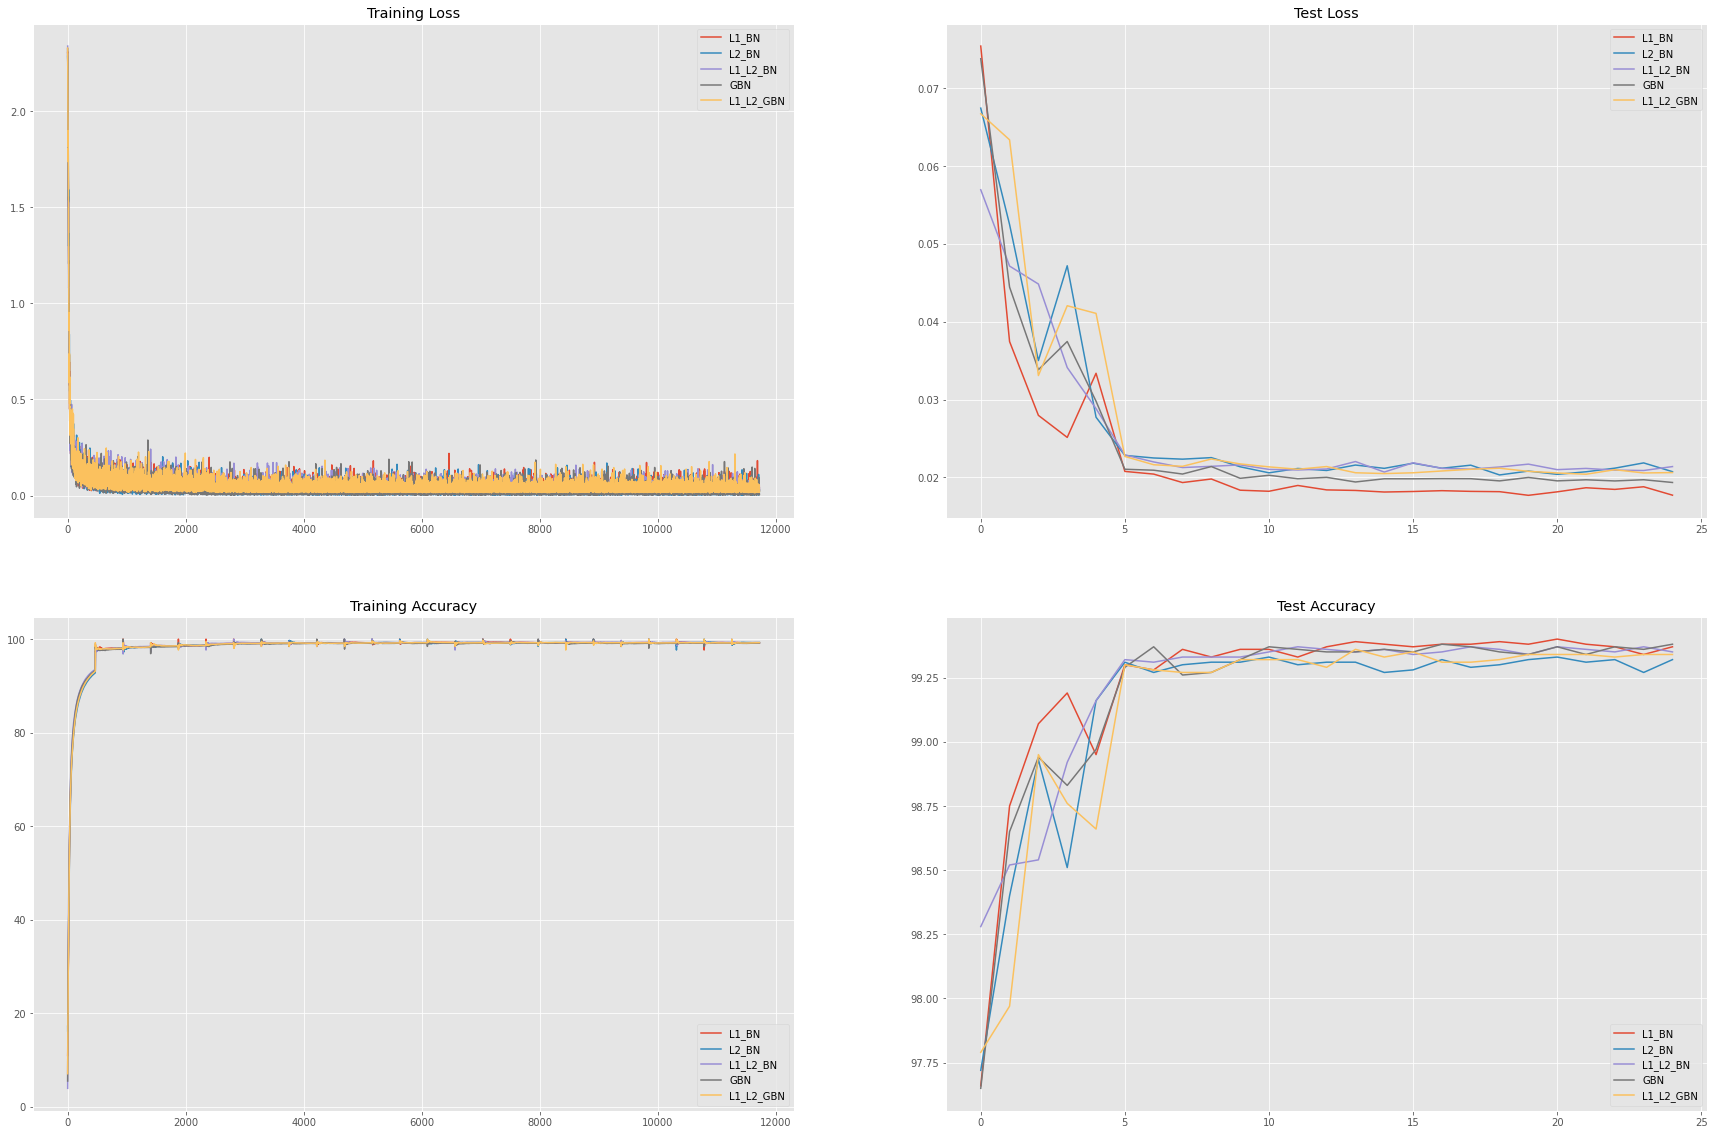

In [17]:
plt.style.use('ggplot')

fig, axs = plt.subplots(2,2,figsize=(30,20))
for m_num in range(MODELS):
  axs[0, 0].plot(tr_ls_dict[m_num],label=model_dict[m_num] )
  axs[0, 0].legend(loc="upper right")
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(tr_acc_dict[m_num],label=model_dict[m_num])
  axs[1, 0].legend(loc="lower right")
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(ts_ls_dict[m_num],label=model_dict[m_num])
  axs[0, 1].legend(loc="upper right")
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(ts_acc_dict[m_num],label=model_dict[m_num])
  axs[1, 1].legend(loc="lower right")
  axs[1, 1].set_title("Test Accuracy")

# Check for incorrectly classified images

In [13]:
l1_model = Net(is_gbn=True)
model_file_name = 'l1_norm'
l1_model.load_state_dict(torch.load(base_folder+model_file_name+"GBN_sd.pth")) # Load GBN Model

imgs = []
labels = []
preds = []
for img, target in test_loader:
  imgs.append( img )
  labels.append( target )
  preds.append( torch.argmax(l1_model(img), dim=1) )

imgs = torch.cat(imgs, dim=0)
labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)

matches = preds.eq(labels)

In [14]:
!ls drive/'My Drive'/eva5_stored_from_colab/s6/l1_normGBN_sd.pth

'drive/My Drive/eva5_stored_from_colab/s6/l1_normGBN_sd.pth'


In [15]:
def create_plot_pos(nrows, ncols):
  num_images = nrows * ncols
  positions = []
  for r in range(num_images):
    row = r // ncols
    col = r % ncols
    positions.append((row, col))
  return positions

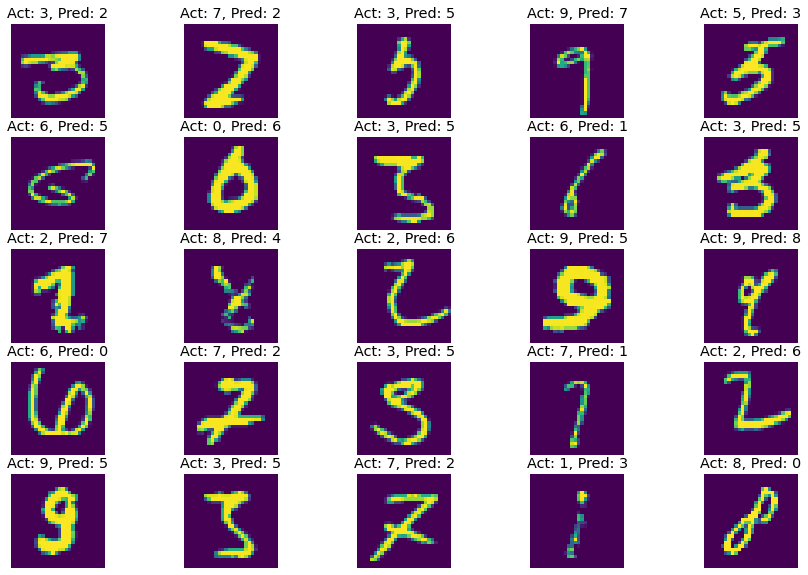

In [16]:
idx = 0
nrows = 5
ncols = 5
skip = 25

total_imgs = nrows*ncols
pos = create_plot_pos(5, 5)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 10), sharex=True, sharey=True)

idx = 0
posidx = 0
total_skipped = 0
for m in matches:
  if posidx > total_imgs-1:
    break

  if not m:
    if total_skipped <= skip:
      total_skipped += 1
      idx += 1
      continue

    img = imgs[idx].reshape(28,28)
    title = "Act: " + str(labels[idx].item()) + ", Pred: " + str(preds[idx].item())
    chart_pos = pos[posidx]
    axes[chart_pos].imshow(img)
    axes[chart_pos].set_title(title)
    axes[chart_pos].axis("off")

    posidx += 1
  
  idx += 1
